# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


In [4]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_mtx(
    '/Users/student/Desktop/BP205B/HCC_AA/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/Users-student-Desktop-BP205B-HCC_AA-matrix.h5ad


In [6]:
barcode_meta = pd.read_csv("./AA_barcode_identities.csv", sep=',', index_col =1)

barcode_meta.index = barcode_meta.apply(lambda x: x.name + "-1", axis=1)

print(len(adata.obs.index), len(np.intersect1d(adata.obs.index, barcode_meta.index)))
barcode_meta = barcode_meta.replace({'GCCAGTTA':'LM2-B','CACTGTAG':'Parental','TGCCGTGG':'LM2-C'})
barcode_meta

4151 3568


Unnamed: 0 multiseq_barcode
GGATGTTCAGTACACT-1           0            LM2-B
TTAGGACCAATGGAGC-1           1            LM2-C
CGCTGGAAGCTCTCGG-1           2         Parental
TACGGATAGGCGATAC-1           3         Parental
CCTAAAGGTGCTTCTC-1           4            LM2-C
...                        ...              ...
TGACTTTAGCTGGAAC-1        3563            LM2-B
TGGGAAGGTTAAAGTG-1        3564            LM2-B
AACTGGTTCACAAACC-1        3565            LM2-B
GACTGCGCAGCTGCTG-1        3566            LM2-B
CCGTACTAGAATTGTG-1        3567            LM2-B

[3568 rows x 2 columns]

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata.obs['multiseq'] = barcode_meta.loc[adata.obs.index, 'multiseq_barcode']

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


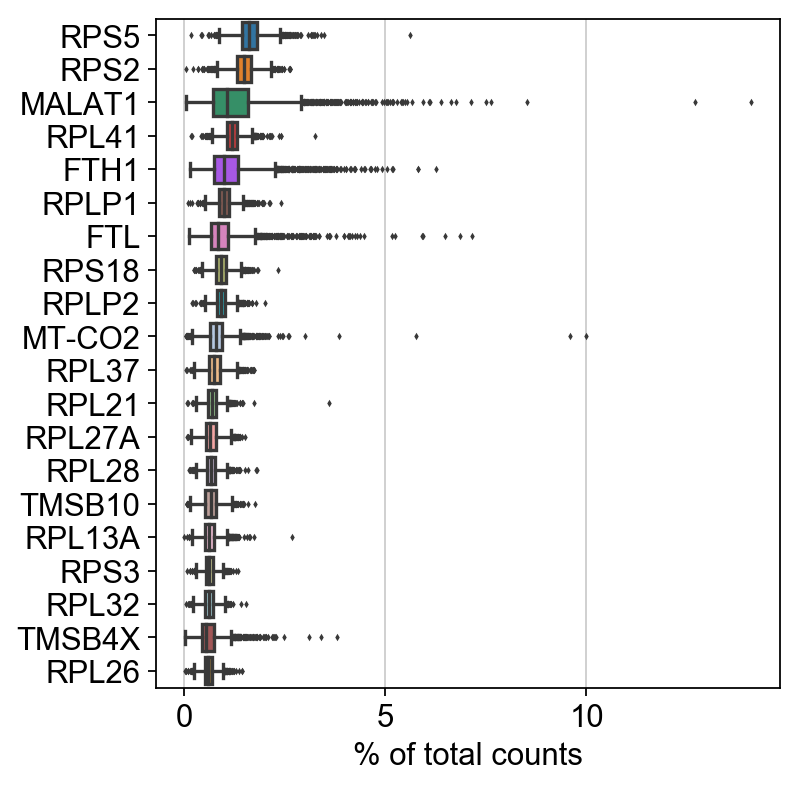

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering.

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16935 genes that are detected in less than 3 cells


Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [13]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

... storing 'multiseq' as categorical


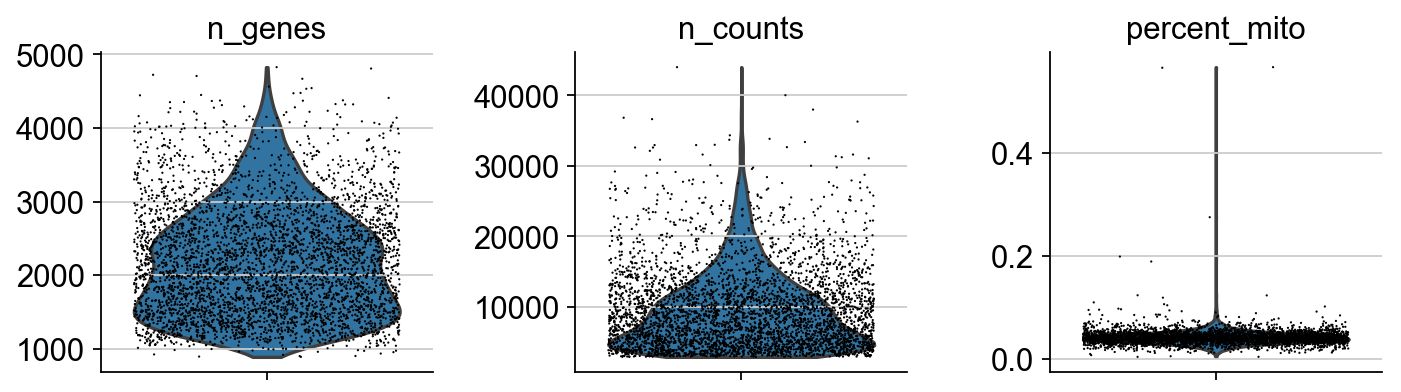

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

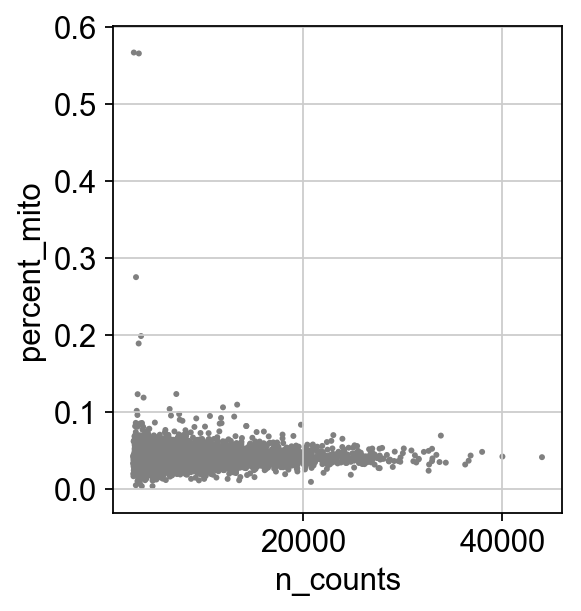

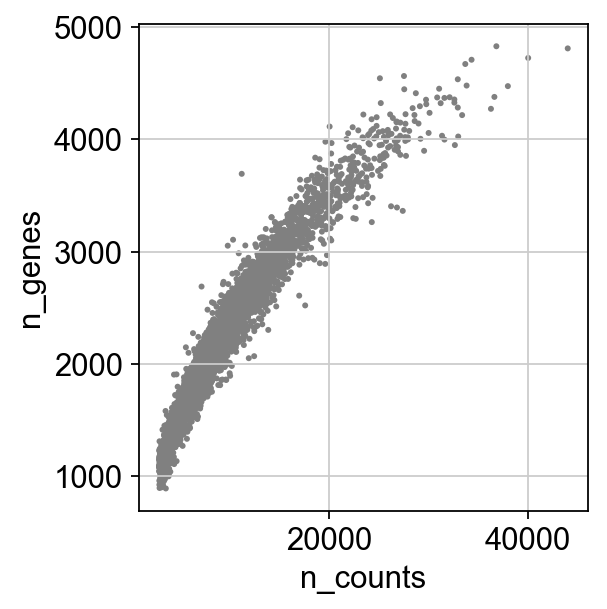

In [16]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

filter out cells without multiseq barcode

In [18]:
adata = adata[adata.obs.multiseq != 'nan', :]

Actually do the filtering.

In [20]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.1, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:05)


Logarithmize the data.

In [23]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data in `.raw`.

In [24]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Identify highly-variable genes.

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [26]:
adata.var[adata.var.highly_variable == True]

gene_ids  n_cells  highly_variable     means  \
RP11-206L10.9  ENSG00000237491       79             True  0.024490   
SAMD11         ENSG00000187634      813             True  0.235925   
HES4           ENSG00000188290     3221             True  1.238371   
ISG15          ENSG00000187608     3494             True  1.371338   
MORN1          ENSG00000116151      119             True  0.032271   
...                        ...      ...              ...       ...   
COL18A1        ENSG00000182871       77             True  0.023273   
MCM3AP-AS1     ENSG00000215424       84             True  0.024707   
YBEY           ENSG00000182362      234             True  0.067568   
MT-ND6         ENSG00000198695     2618             True  0.926476   
AC007325.4     ENSG00000278817      294             True  0.078976   

               dispersions  dispersions_norm  
RP11-206L10.9     0.676405          1.528351  
SAMD11            0.497450          0.630243  
HES4              0.790561          0.755106  
ISG15             0.841917          0.525219  
MORN1             0.472974          0.507410  
...                    ...               ...  
COL18A1           0.513804          0.712315  
MCM3AP-AS1        0.532126          0.804271  
YBEY              0.515224          0.719446  
MT-ND6            0.777450          1.442181  
AC007325.4        0.485683          0.571189  

[1748 rows x 6 columns]

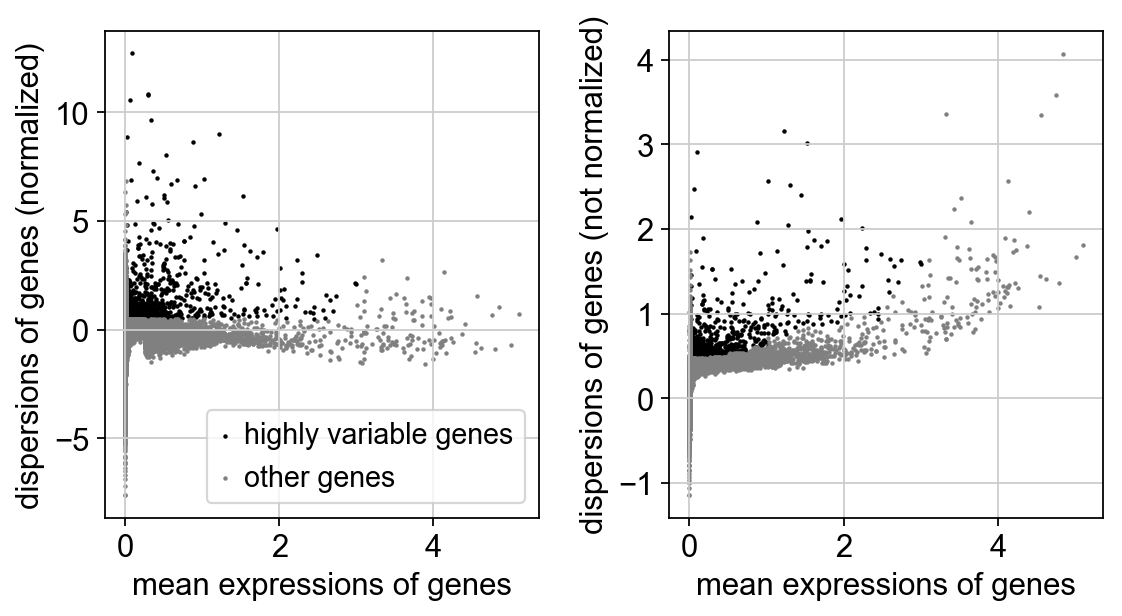

In [27]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [28]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [30]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [32]:
sc.pp.scale(adata, max_value=10)

## Regress out cell cycle genes

In [34]:
import urllib.request
cell_cycle_genes = [x.strip().decode('utf-8') for x in urllib.request.urlopen('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


In [35]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


... storing 'phase' as categorical


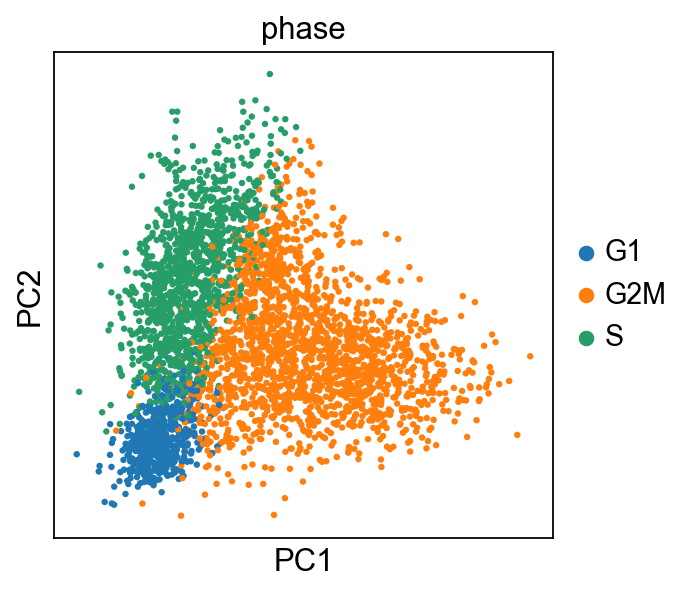

In [36]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')


In [37]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:05)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


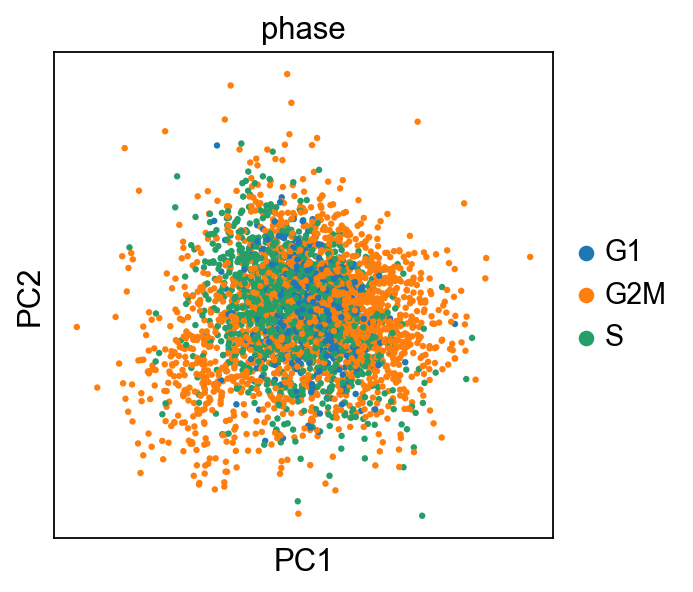

In [38]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [39]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


In [40]:
adata

AnnData object with n_obs × n_vars = 3559 × 1748 
    obs: 'multiseq', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

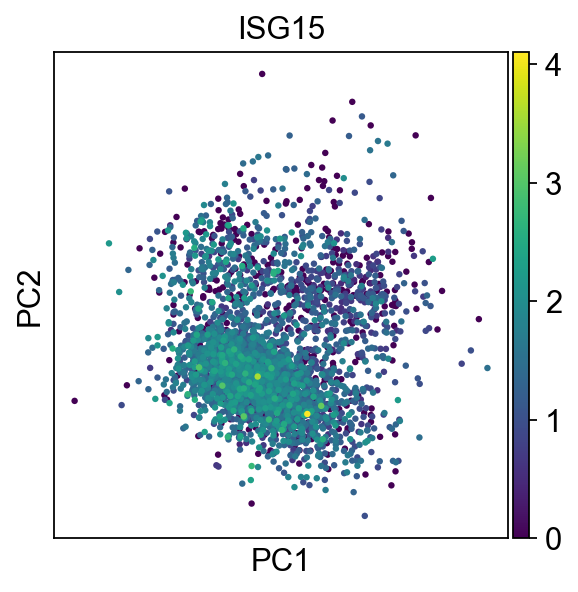

In [41]:
sc.pl.pca(adata, color='ISG15')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

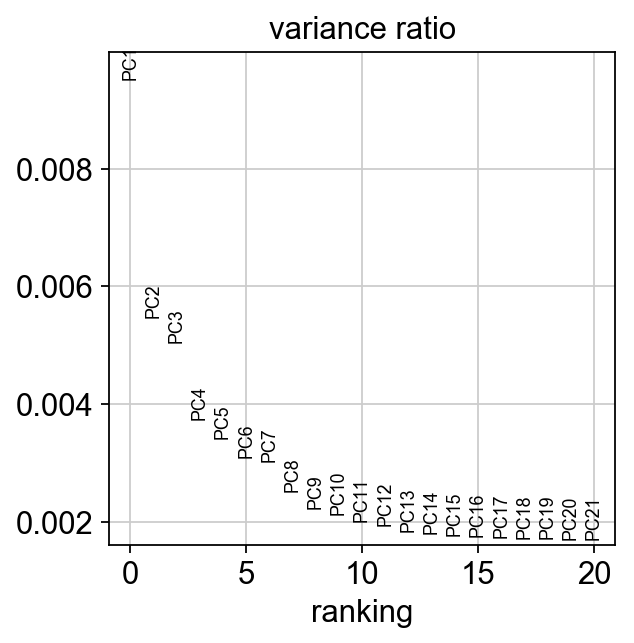

In [42]:
sc.pl.pca_variance_ratio(adata, log=False,n_pcs = 20)

Save the result.

In [43]:
adata.write(results_file)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=13)

computing neighbors
    using 'X_pca' with n_pcs = 13
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [45]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [46]:
adata.obsm['X_umap']

array([[ 0.95508546, -4.7730494 ],
       [ 4.570091  , -1.5815139 ],
       [ 5.67943   ,  0.498381  ],
       ...,
       [-3.4126706 , -2.5428505 ],
       [-0.33714336, -3.9532406 ],
       [ 2.503993  , -1.5165982 ]], dtype=float32)

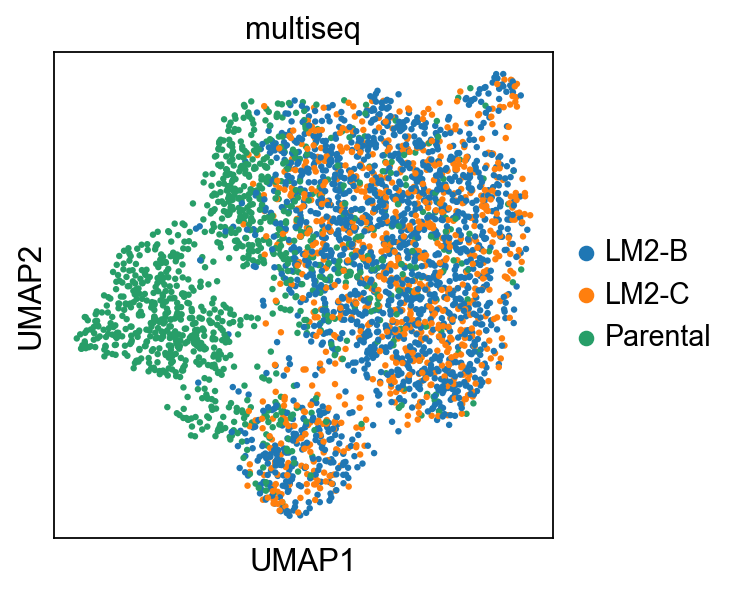

In [47]:
sc.pl.umap(adata, color=['multiseq'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

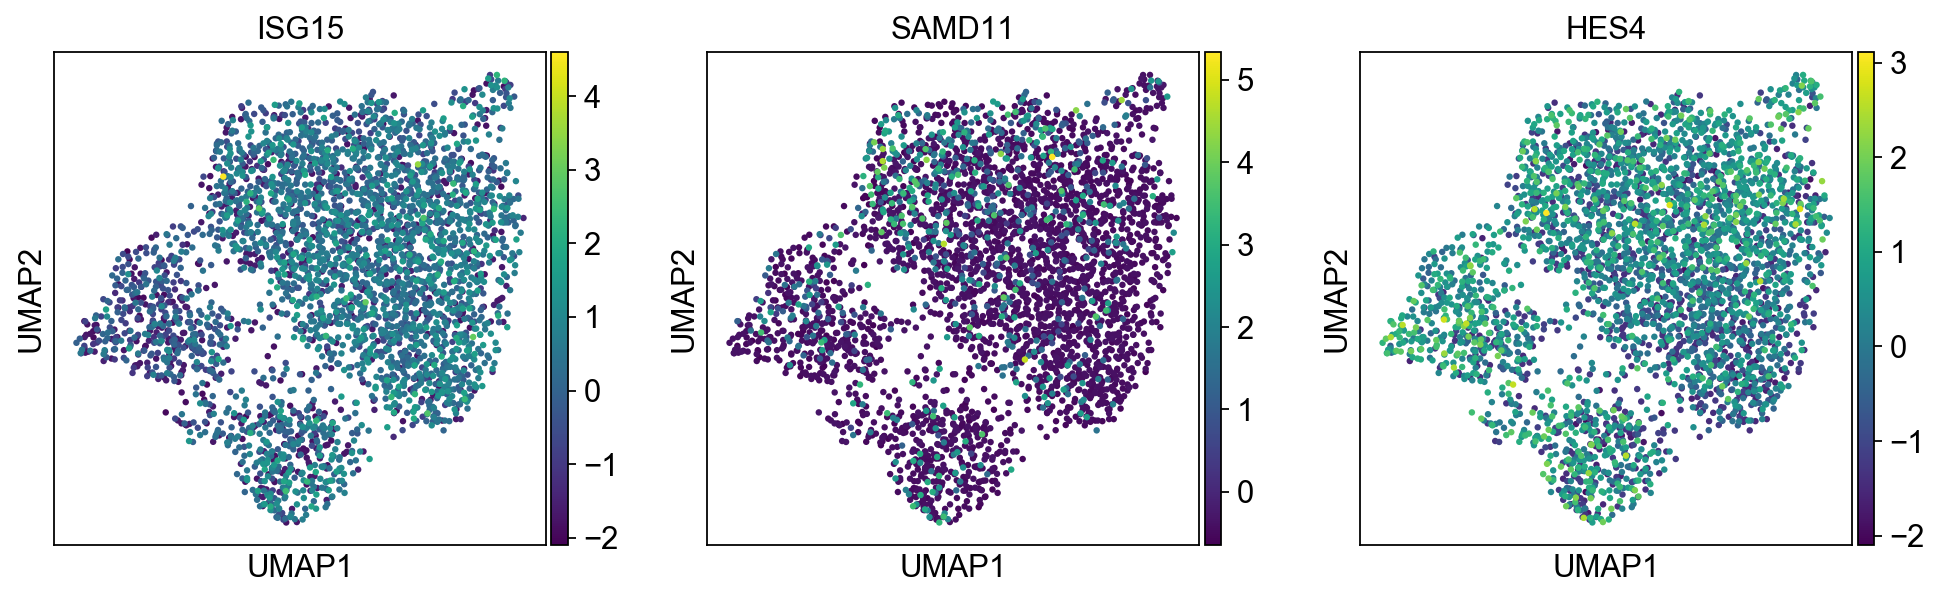

In [48]:
sc.pl.umap(adata, color=['ISG15', 'SAMD11', 'HES4'], use_raw=False)

In [49]:
adata.var

gene_ids  n_cells  highly_variable     means  \
RP11-206L10.9  ENSG00000237491       79             True  0.024490   
SAMD11         ENSG00000187634      813             True  0.235925   
HES4           ENSG00000188290     3221             True  1.238371   
ISG15          ENSG00000187608     3494             True  1.371338   
MORN1          ENSG00000116151      119             True  0.032271   
...                        ...      ...              ...       ...   
COL18A1        ENSG00000182871       77             True  0.023273   
MCM3AP-AS1     ENSG00000215424       84             True  0.024707   
YBEY           ENSG00000182362      234             True  0.067568   
MT-ND6         ENSG00000198695     2618             True  0.926476   
AC007325.4     ENSG00000278817      294             True  0.078976   

               dispersions  dispersions_norm  
RP11-206L10.9     0.676405          1.528351  
SAMD11            0.497450          0.630243  
HES4              0.790561          0.755106  
ISG15             0.841917          0.525219  
MORN1             0.472974          0.507410  
...                    ...               ...  
COL18A1           0.513804          0.712315  
MCM3AP-AS1        0.532126          0.804271  
YBEY              0.515224          0.719446  
MT-ND6            0.777450          1.442181  
AC007325.4        0.485683          0.571189  

[1748 rows x 6 columns]

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [50]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

In [51]:
x = adata.obs.groupby(by = ['leiden', 'multiseq']).size() / adata.obs.groupby(by = 'leiden').size()

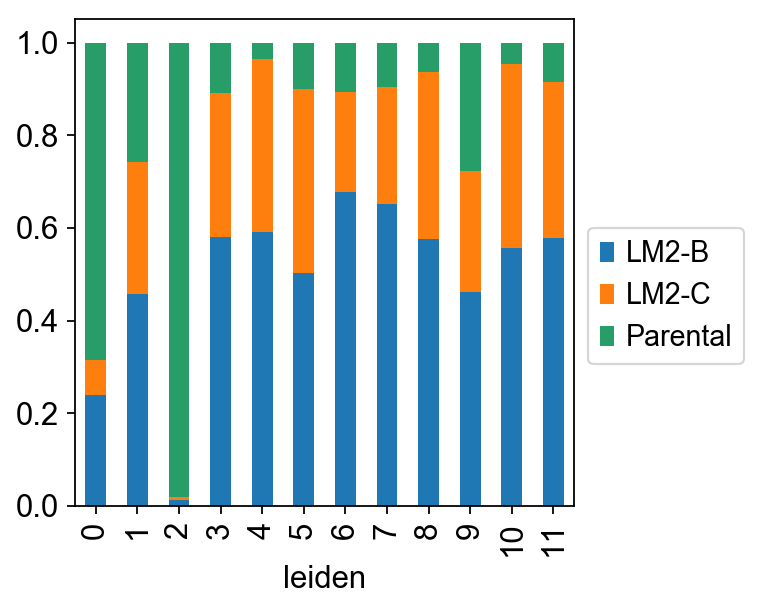

In [52]:
ax = x.unstack().plot(kind='bar', stacked = True)
ax.legend(bbox_to_anchor=(1, .6))
ax.grid(b=None)

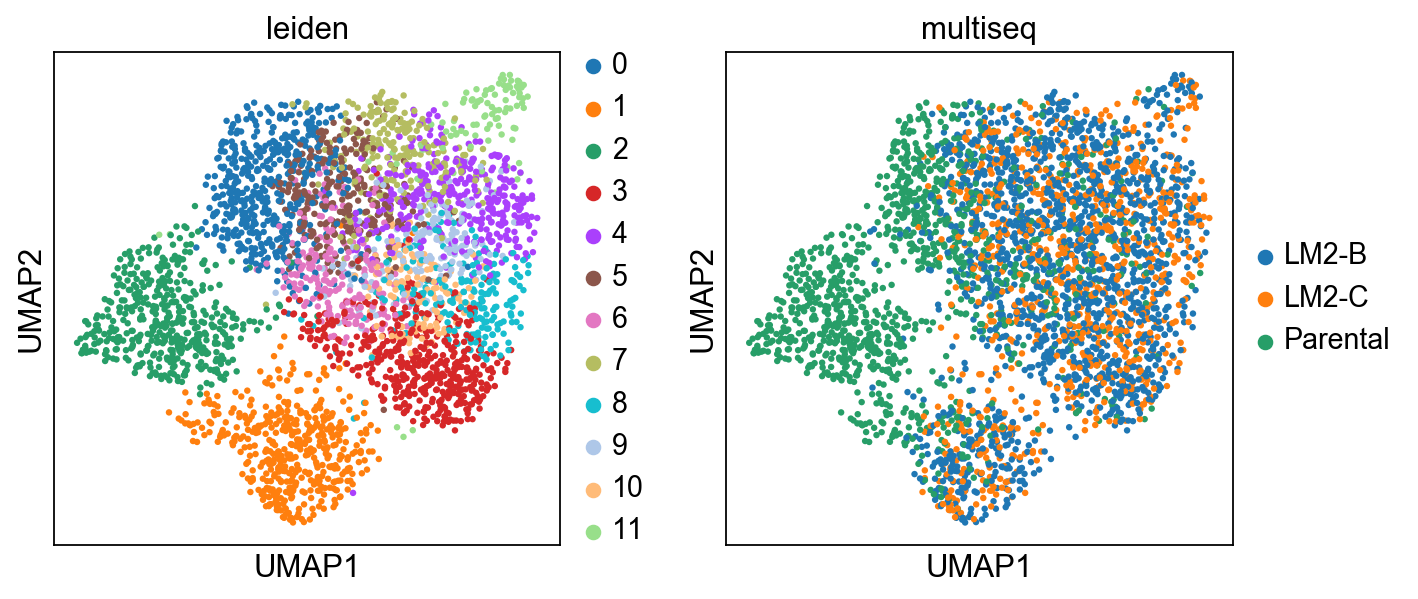

In [85]:
sc.pl.umap(adata, color=['leiden', 'multiseq'])

Save the result.

In [55]:
adata.write(results_file)

In [56]:
adata.var_names

Index(['RP11-206L10.9', 'SAMD11', 'HES4', 'ISG15', 'MORN1', 'RP3-395M20.12',
       'TP73', 'SMIM1', 'RP1-202O8.3', 'HES2',
       ...
       'BRWD1', 'MX2', 'TFF2', 'TMPRSS3', 'SIK1', 'COL18A1', 'MCM3AP-AS1',
       'YBEY', 'MT-ND6', 'AC007325.4'],
      dtype='object', length=1748)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


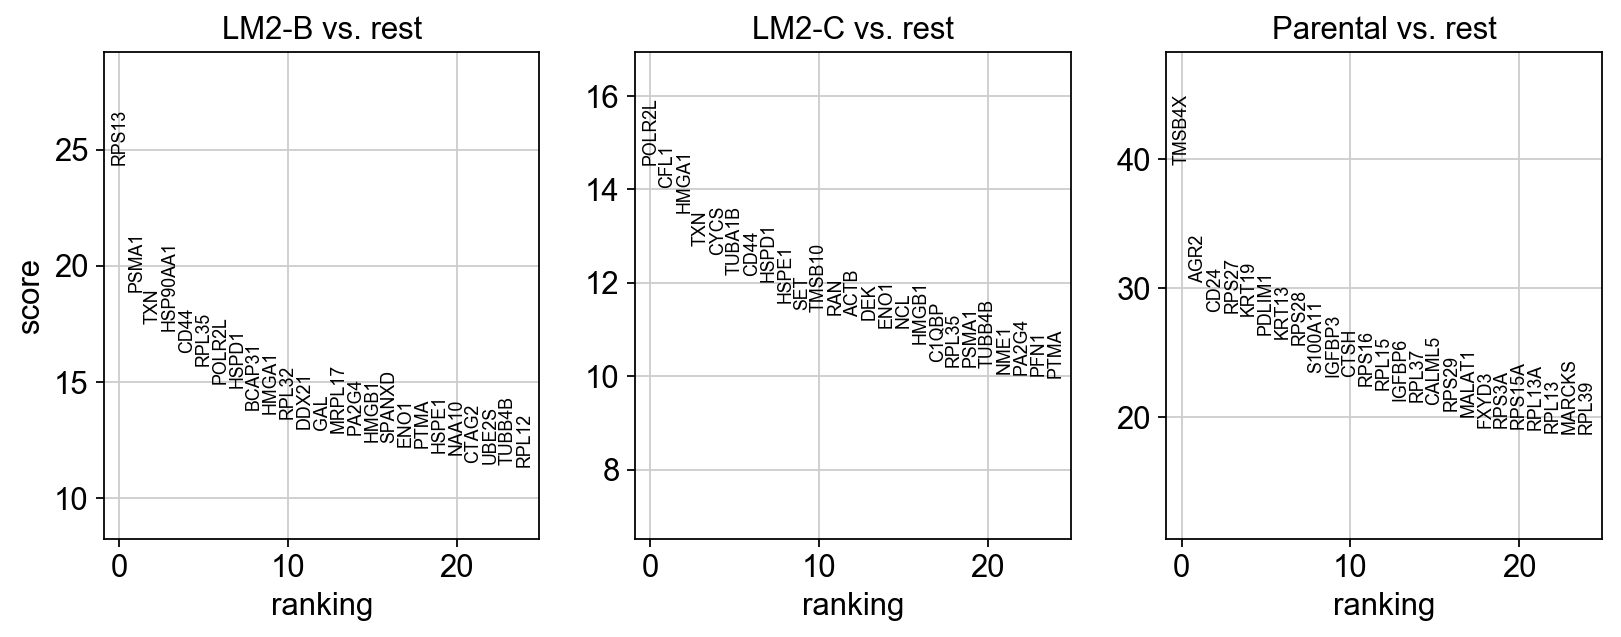

In [57]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [58]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:03)


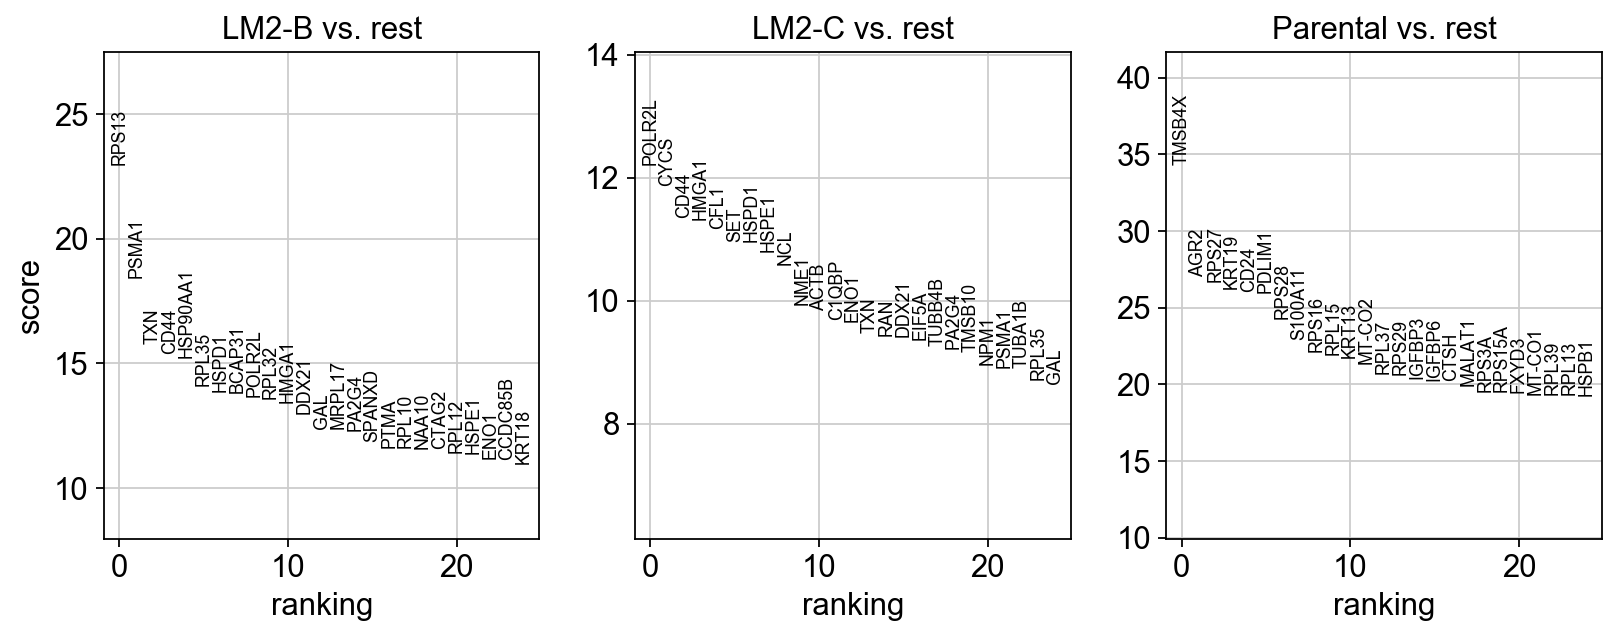

In [59]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [60]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:04)


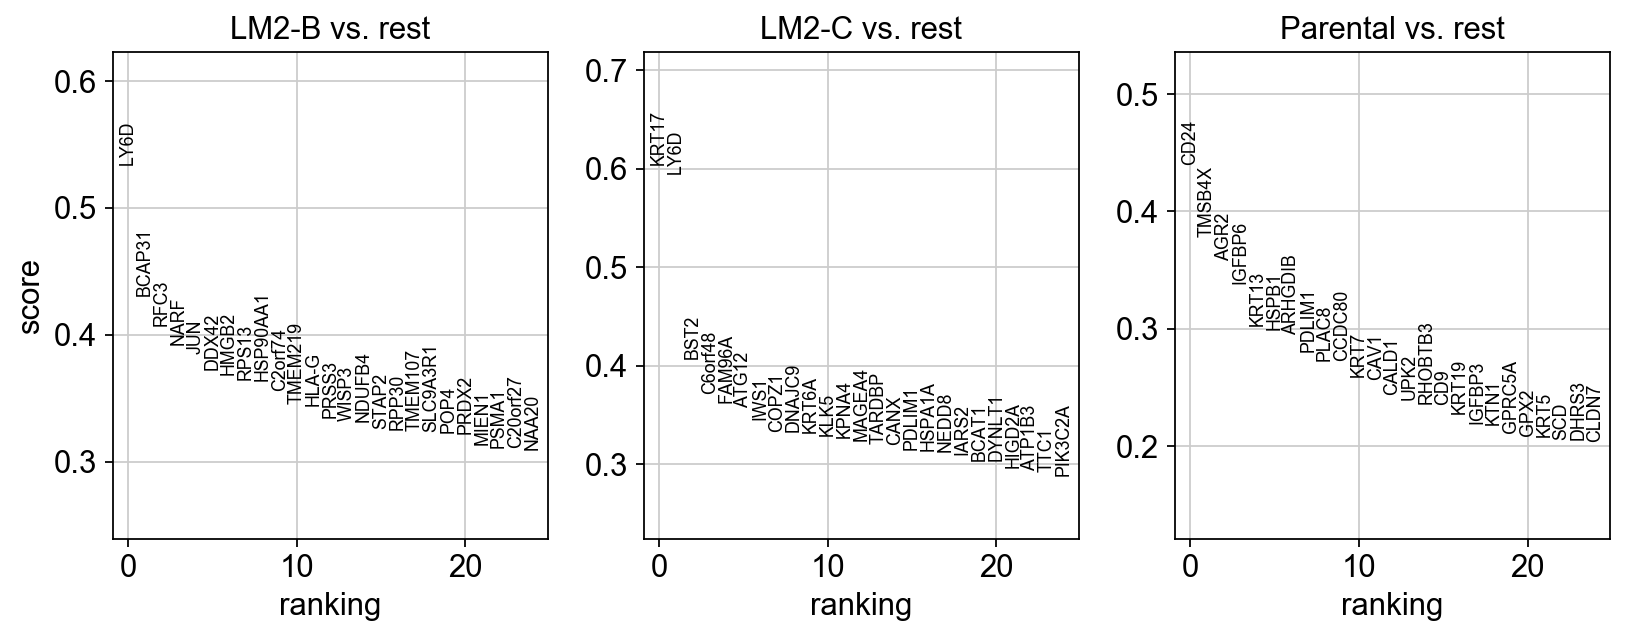

In [61]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

High Mobility Group A (HMGA) proteins: form “enhanceosomes” on the promoter/enhancer regions of
genes that regulate gene transcription，oncogenic driver of progression
CFL1: is able to bind both G-actin (monomeric) and F-actin (filamentous) and is one of the major proteins responsible for cell migration processes through regulating actin filament dynamics. In tumor cells, the CFL pathway is essential for epithelial–mesenchymal transition.

In [62]:
marker_genes = ['RPS13', 'PSMA1','TXN','POLR2L', 'HSPD1','HMGA1','CD44','TMSB4X', 'CD24','AGR2','PDLIM1']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [63]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [64]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

LM2-B   LM2-C Parental
0     RPS13  POLR2L   TMSB4X
1     PSMA1    CYCS     AGR2
2       TXN    CD44    RPS27
3      CD44   HMGA1    KRT19
4  HSP90AA1    CFL1     CD24

Get a table with the scores and groups.

In [65]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

LM2-B_n        LM2-B_p LM2-C_n       LM2-C_p Parental_n     Parental_p
0     RPS13  6.658139e-117  POLR2L  2.619669e-34     TMSB4X  1.642863e-258
1     PSMA1   7.261144e-76    CYCS  1.631803e-32       AGR2  6.612892e-161
2       TXN   4.980628e-56    CD44  7.569887e-30      RPS27  5.190590e-157
3      CD44   1.492898e-53   HMGA1  1.070047e-29      KRT19  2.224161e-151
4  HSP90AA1   2.564616e-52    CFL1  6.223987e-29       CD24  4.521494e-149

Compare to a single cluster. 

ranking genes
    finished (0:00:02)


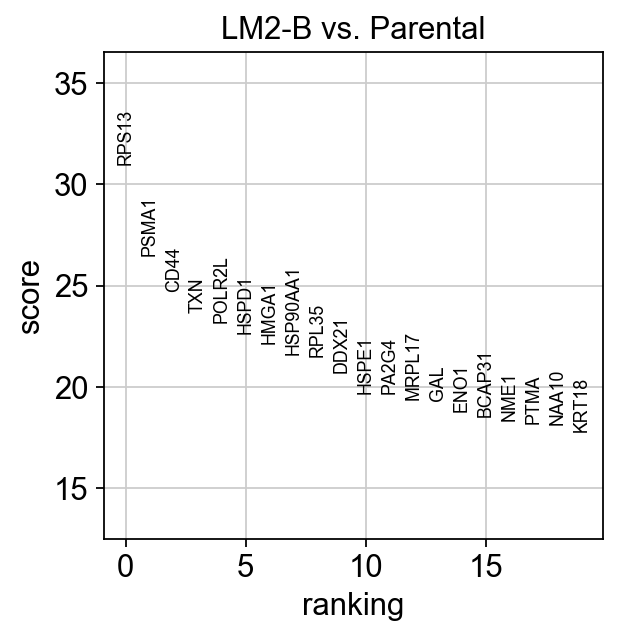

In [66]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['LM2-B'], reference='Parental', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['LM2-B'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/usr/local/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


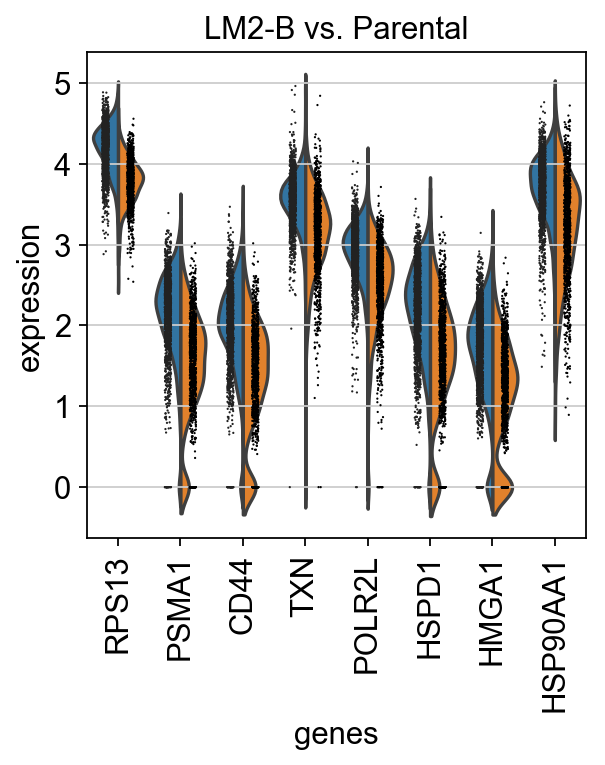

In [67]:
sc.pl.rank_genes_groups_violin(adata,groups = ['LM2-B'], n_genes=8)

ranking genes
    finished (0:00:02)


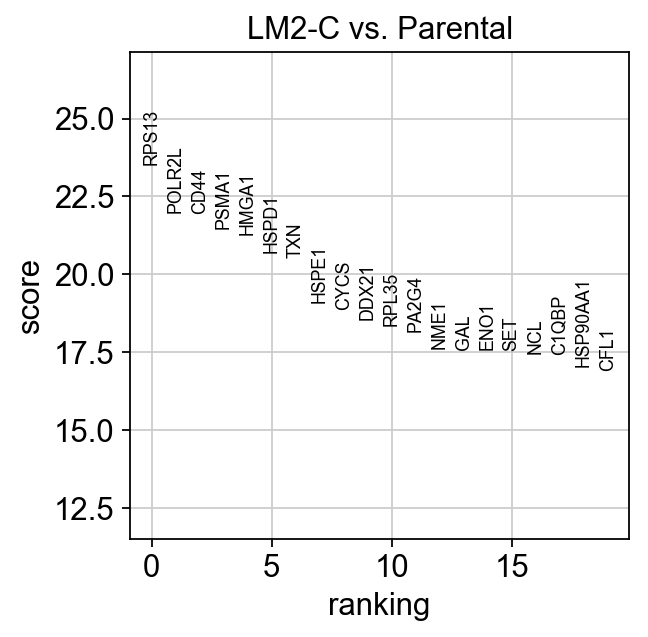

In [68]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['LM2-C'], reference='Parental', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['LM2-C'], n_genes=20)

/usr/local/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


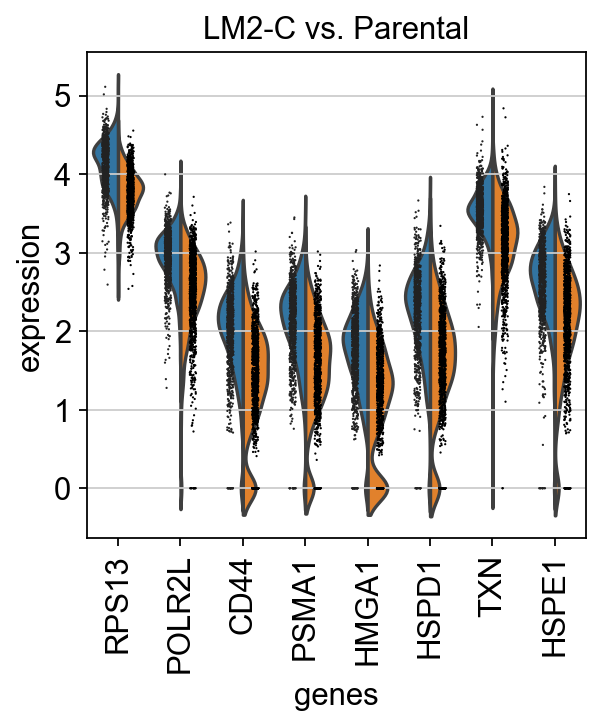

In [69]:
sc.pl.rank_genes_groups_violin(adata,groups = ['LM2-C'], n_genes=8)

ranking genes
    finished (0:00:02)


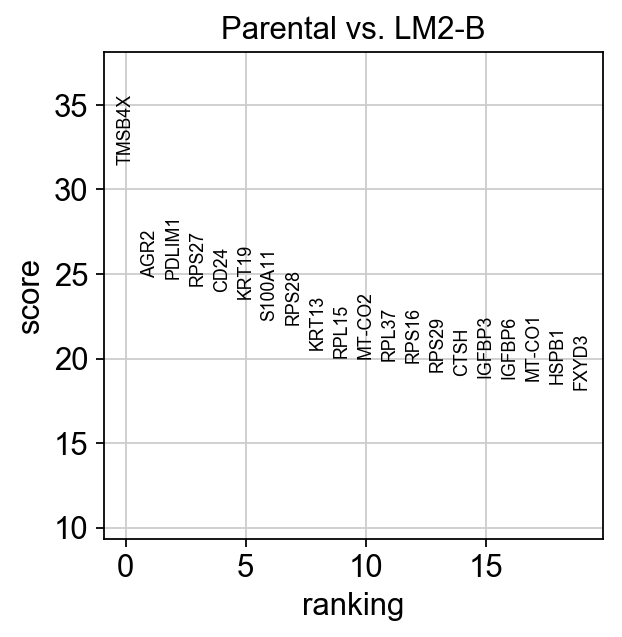

In [70]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['Parental'], reference='LM2-B', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['Parental'], n_genes=20)

/usr/local/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


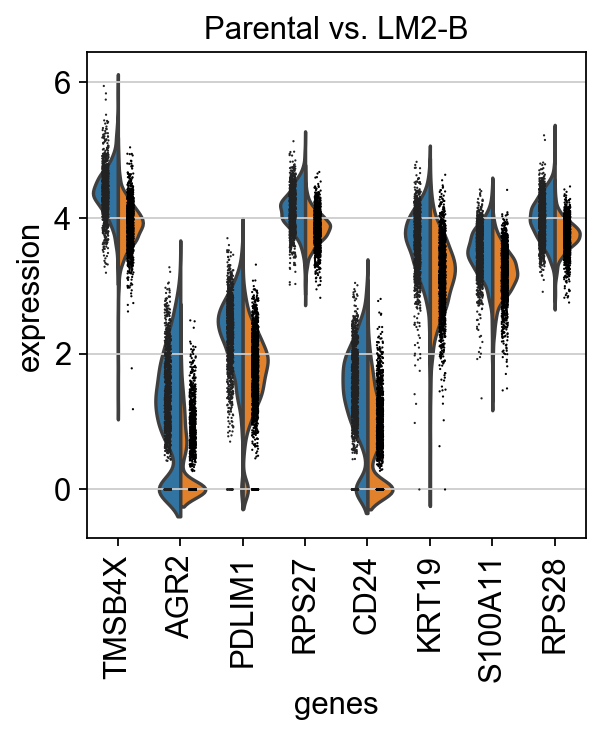

In [71]:
sc.pl.rank_genes_groups_violin(adata,groups = ['Parental'], n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [72]:
adata = sc.read(results_file)

If you want to compare a certain gene across groups, use the following.

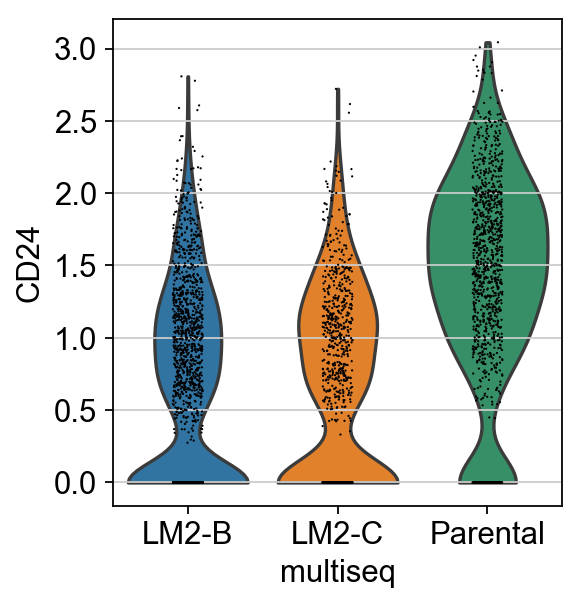

In [73]:
sc.pl.violin(adata, ['CD24'], groupby='multiseq')

Actually mark the cell types.

In [74]:
new_cluster_names = [
    'LM2-B', 'LM2-C',
    'Parental' 
    ]
adata.rename_categories('multiseq', new_cluster_names)

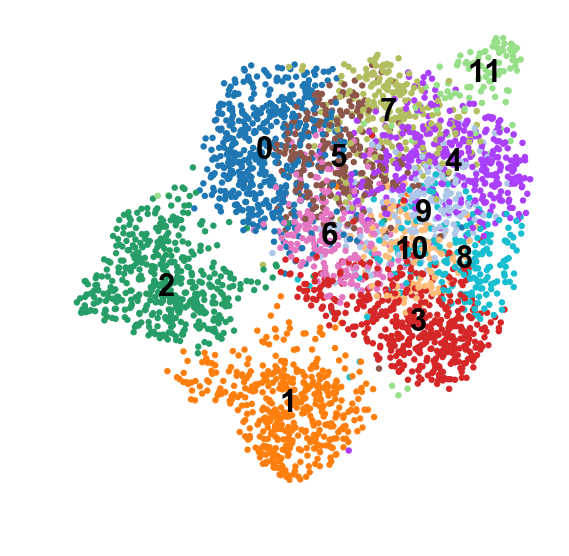

In [75]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

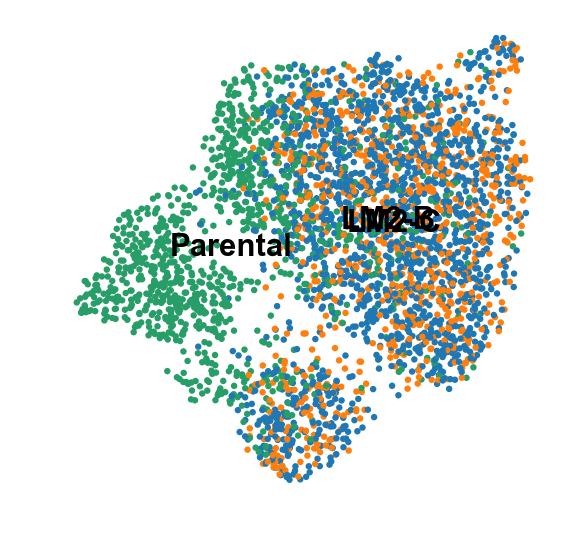

In [76]:
sc.pl.umap(adata, color='multiseq', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

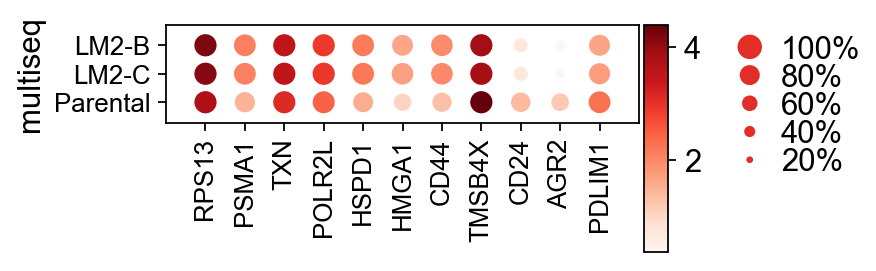

In [77]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='multiseq')

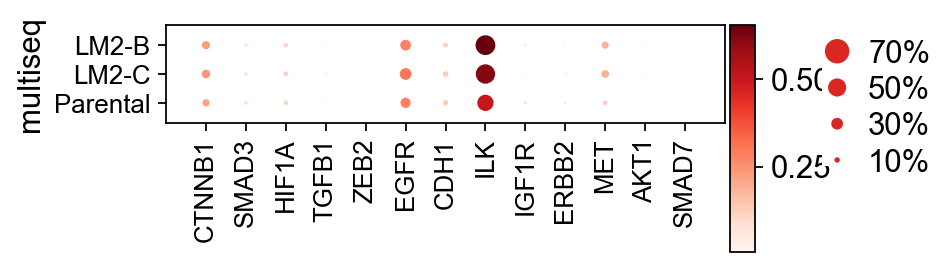

In [78]:
EMT_genes = ['CTNNB1','SMAD3','HIF1A','TGFB1','ZEB2','EGFR','CDH1','ILK','IGF1R','ERBB2','MET','AKT1','SMAD7']
ax = sc.pl.dotplot(adata, EMT_genes, groupby='multiseq')

There is also a very compact violin plot.

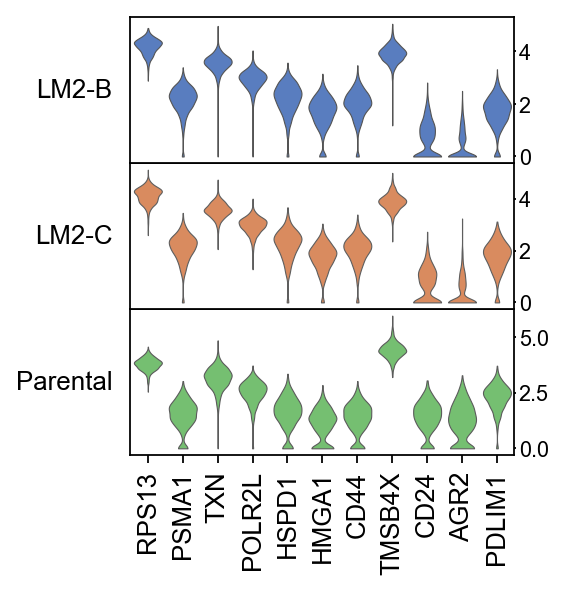

In [79]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='multiseq', rotation=90)

In [80]:
adata.obs.multiseq

index
AAACCTGCAATCGGTT-1       LM2-C
AAACCTGGTAGGCATG-1       LM2-B
AAACCTGGTCGTGGCT-1       LM2-B
AAACCTGGTTCTGGTA-1    Parental
AAACCTGGTTGTCTTT-1    Parental
                        ...   
TTTGTCAGTTCAGACT-1       LM2-C
TTTGTCAGTTGCGCAC-1       LM2-B
TTTGTCATCCTCGCAT-1    Parental
TTTGTCATCTCTTATG-1       LM2-C
TTTGTCATCTTTAGTC-1       LM2-C
Name: multiseq, Length: 3559, dtype: category
Categories (3, object): [LM2-B, LM2-C, Parental]

During the course of this analysis, the AnnData accumlated the following annotations.

In [81]:
adata

AnnData object with n_obs × n_vars = 3559 × 1748 
    obs: 'multiseq', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'multiseq_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [82]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [83]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [84]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )